### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import from_json
from pyspark.ml.feature import VectorAssembler

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### read traces from hadoop
*path_on_hdfs_to_your_data*

In [3]:
df = spark.read.json("/user/rucio01/traces/traces.2018-04*")

In [5]:
df.head()

Row(account=u'pilot', appid=None, catStart=None, clientState=u'DONE', dataset=u'', datasetName=None, datasetScope=u'', dataset_scope=None, duid=None, eventType=u'download', eventVersion=u'1.14.11', filename=u'EventService_premerge_3886111819_13607623-3886111819-13041798597-3795-10.tar', filesize=None, guid=None, hostname=u'b6ac037cc1.cern.ch', ip=None, localSite=None, name=None, pq=None, protocol=u's3', relativeStart=None, remoteSite=u'CERN-PROD_ES', scope=u'transient', stateReason=None, suspicious=None, taskid=None, timeEnd=None, timeStart=None, traceId=u'e68c1b1bbee84d5a96dcfc2f38dc26bb', traceIp=u'::ffff:188.184.146.18', traceTimeentry=u'2018-03-31T22:00:00.005599', traceTimeentryUnix=1522533600.005599, transferEnd=1522533599.975359, transferStart=1522533588.042424, url=None, usr=None, usrdn=None, uuid=u'53cf181ec38b4e2a8885b2a81109d505', validateStart=None, version=None)

### Create temporary table view

In [6]:
# body_schema = spark.read.json(df_loadAvg.rdd.map(lambda row: row.body)).schema
df.createOrReplaceTempView("traces")

### Use PySpark to query download events and split dataset DID into new features

In [7]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 25)

In [9]:
df = spark.sql("SELECT *  \
                    FROM traces \
                    WHERE eventType=='download'")\

In [10]:
# replacing null values in column account with the value of column eventVersion of the same row
# df_ps2 = df_ps.withColumn("account",coalesce(df.account,df.eventVersion))
# df_ps2.show(n=5)

#df_ps = df_ps.dropna()

In [11]:
split_col = split(df['dataset'], "\.")
df = df.withColumn('project', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(0)).otherwise(None))
df = df.withColumn('run_number', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(1)).otherwise(None))
df = df.withColumn('stream_name', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(2)).otherwise(None))
df = df.withColumn('prod_step', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(3)).otherwise(None))
df = df.withColumn('datatype', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(4)).otherwise(None))
df = df.withColumn('dataset_version', when(df['dataset'].like('mc%') | df['dataset'].like('data%'), split_col.getItem(5)).otherwise(None))

### get table summary

In [12]:
df.describe().toPandas()

summary   account   appid catStart   clientState  \
0  count   29380506  102358  0        29380506       
1  mean    None      None    None     None           
2  stddev  None      None    None     None           
3  min     aad       [null]  None     ALREADY_DONE   
4  max     zzheng    [null]  None     TypeError      

                                                                                 dataset  \
0  29346259                                                                                
1  None                                                                                    
2  None                                                                                    
3                                                                                          
4  valid3.110401.PowhegPythia_P2012_ttbar_nonallhad.simul.log.e2928_s3213_tid12503332_00   

                                                                                                                datasetName  \
0  34222                                                                                                                      
1  None                                                                                                                       
2  None                                                                                                                       
3                                                                                                                             
4  mc16_13TeV.364197.Sherpa_221_NNPDF30NNLO_Wtaunu_MAXHTPTV1000_E_CMS.merge.NTUP_PILEUP.e5340_s3126_r9364_r9315_p3127_p3126   

  datasetScope  dataset_scope  duid       ...       usrdn  \
0  29380051     455            0          ...        0      
1  None         None           None       ...        None   
2  None         None           None       ...        None   
3                              None       ...        None   
4  valid3       user.mlassnig  None       ...        None   

                               uuid validateStart version     project  \
0  29380506                          0             0       1645429      
1  Infinity                          None          None    None         
2  NaN                               None          None    None         
3  00000020aa454d50a6433fb21d506632  None          None    data10_hi    
4  ffffffac11ab4dfc9a60d885bf8452b7  None          None    mc16_valid   

         run_number                                   stream_name prod_step  \
0  1645429           1645429                                       1645429    
1  346682.429148734  None                                          None       
2  55703.7629481591  None                                          None       
3  00169927          AcerMCPythia_P2011CCTEQ6L1_singletop_tchan_l  PhysCont   
4  periodM           physics_bulk                                  simul      

  datatype dataset_version  
0  1645429  1639132         
1  None     None            
2  None     None            
3  AOD      c1130_m1847     
4  log      x557_m1947      

[5 rows x 47 columns]

In [13]:
df.createOrReplaceTempView("traces")

### create new table that counts all downloads per dataset

In [14]:
df_counts = spark.sql("SELECT dataset AS dataset_counts, count(*) as hits \
                               FROM traces \
                               GROUP BY  dataset \
                               ORDER BY 2 DESC")

In [15]:
df_counts.createOrReplaceTempView("counts")

### join both tables

In [16]:
df_merged = spark.sql("SELECT * \
                               FROM traces \
                               LEFT JOIN counts ON traces.dataset = counts.dataset_counts")

In [17]:
df_merged = df_merged.drop('dataset_counts')

In [18]:
# refresh merged view so that all columns are in it
df_merged.createOrReplaceTempView("merged")

In [62]:
pandas_data = df_merged.limit(2000).toPandas()

In [20]:
df_merged.count()

29380506

In [21]:
df.count()

29380506

In [22]:
#df_merged.write.format("json").save("/user/sprenner/data_plot.json")

### Plot subset of merged table

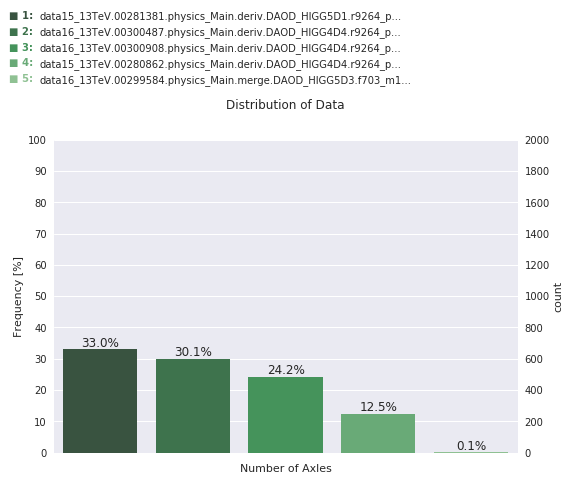

In [97]:
#https://stackoverflow.com/questions/43585333/seaborn-countplot-set-legend-for-x-values
#https://stackoverflow.com/questions/45013645/how-to-handle-long-axis-labels-with-seaborn


import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]
    
    
plt.gcf().clear()
plt.figure(figsize=(12,8))

fig, ax = plt.subplots()
idx = pd.value_counts(pandas_data['dataset']).iloc[:10].index
ax = sns.countplot(x="dataset", data=pandas_data, palette="Greens_d", order=idx)
plt.title('Distribution of Data', y=1.08)
plt.xlabel('Number of Axles')
ncount = pandas_data.shape[0]
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

top_ten_list = list(idx.values)
handltext = []

for idx, val in enumerate(top_ten_list):
    handltext.append(u"\u25A0" + " " + str(idx + 1) + ":")    
    
labels = ax.get_xticklabels()

labeldic = dict(zip(handltext, labels))
labels = [(labeldic[h].get_text()) if len(labeldic[h].get_text()) < 60 else labeldic[h].get_text()[0:61] + "..." for h in handltext]
handles = [(h,c.get_fc()) for h,c in zip(handltext,ax.patches)]

ax.legend(handles, labels, handler_map={tuple : TextHandler()}, bbox_to_anchor=(-0.1, 1.16, 1., .102), loc=3, ncol=1, mode="expand", borderaxespad=0., frameon=False, edgecolor='white') 
ax.set_xticklabels('')
fig.subplots_adjust(top=0.75)
#plt.show()
ax.get_xticklabels()
plt.tight_layout()